In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential


/Users/xixi/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
BTC = pd.read_csv("weETH_hourly_price_data.csv")
BTC = BTC.rename(columns={'datetime_utc': 'Open Time', 'price_usd': 'Close'})
BTC

,Open Time,Close
0,2025-08-01T14:04:29.259000+00:00,3844.883487
1,2025-08-01T15:01:56.672000+00:00,3894.896883
2,2025-08-01T16:05:40.341000+00:00,3868.430933
3,2025-08-01T17:09:25.637000+00:00,3827.327724
4,2025-08-01T18:04:12.028000+00:00,3827.507799
...,...,...
2156,2025-10-30T09:00:59.471000+00:00,4244.861558
2157,2025-10-30T10:02:03.472000+00:00,4214.102536
2158,2025-10-30T11:01:02.721000+00:00,4204.051699
2159,2025-10-30T12:00:43.337000+00:00,4195.625765


In [3]:
# ================== 1. Data ==================
# 确保按时间排序
BTC = BTC.sort_values('Open Time')

df = BTC[['Open Time', 'Close']].copy()
df['Return'] = df['Close'].pct_change()

# ================== MA 均线 ==================
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# ================== RSI ==================
def compute_RSI(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

df['RSI14'] = compute_RSI(df['Close'], 14)

# ================== MACD ==================
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Hist'] = df['MACD'] - df['Signal']

# ================== Bollinger Bands ==================
window = 20
std = df['Close'].rolling(window).std()
df['BB_Mid'] = df['Close'].rolling(window).mean()
df['BB_Upper'] = df['BB_Mid'] + 2 * std
df['BB_Lower'] = df['BB_Mid'] - 2 * std

# 删除指标计算产生的 NaN（前20行）
df = df.dropna().reset_index(drop=True)

In [4]:
features = ['Close','Return','MA5','MA10','MA20',
            'RSI14','MACD','Signal','MACD_Hist',
            'BB_Mid','BB_Upper','BB_Lower']

data_BTC = df[features].values

In [5]:
# 数据切分
train_size = int(len(data_BTC) * 0.7)
train_data, test_data = data_BTC[:train_size], data_BTC[train_size:]

# 缩放
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# 滑动窗口
def create_dataset(dataset, window=5):
    X, y = [], []
    for i in range(len(dataset) - window):
        X.append(dataset[i:i+window, :])  # 多特征
        y.append(dataset[i+window, 0])    # 预测 Close
    return np.array(X), np.array(y)

window = 5
X_train, y_train = create_dataset(train_scaled, window)
X_test, y_test = create_dataset(test_scaled, window)

# reshape numpy 数组
X_train = X_train.reshape(-1, window, len(features))
X_test  = X_test.reshape(-1, window, len(features))

# 转成 tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_test  = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

# DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train),
                          batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# ================== 2. Model ==================
class LSTMModel(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        input_size = len(features)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden,
                            batch_first=True, dropout=0.2, num_layers=2)
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.lstm(x)  # reset every batch = like Keras
        return self.fc(out[:, -1, :])

model = LSTMModel().to(device)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(init_weights)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.7)

In [7]:
# ================== 3. Training ==================
epochs = 60
for epoch in range(epochs):
    model.train()
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer.zero_grad()
        output = model(Xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss = {loss.item():.6f}, LR={scheduler.get_last_lr()[0]:.6f}")

Epoch 1/60, Loss = 0.010747, LR=0.001000
Epoch 2/60, Loss = 0.001642, LR=0.001000
Epoch 3/60, Loss = 0.002773, LR=0.001000
Epoch 4/60, Loss = 0.001885, LR=0.001000
Epoch 5/60, Loss = 0.001997, LR=0.001000
Epoch 6/60, Loss = 0.001580, LR=0.001000
Epoch 7/60, Loss = 0.001641, LR=0.001000
Epoch 8/60, Loss = 0.001013, LR=0.001000
Epoch 9/60, Loss = 0.000702, LR=0.001000
Epoch 10/60, Loss = 0.002221, LR=0.001000
Epoch 11/60, Loss = 0.002536, LR=0.001000
Epoch 12/60, Loss = 0.001089, LR=0.001000
Epoch 13/60, Loss = 0.001230, LR=0.001000
Epoch 14/60, Loss = 0.000716, LR=0.001000
Epoch 15/60, Loss = 0.000440, LR=0.001000
Epoch 16/60, Loss = 0.000873, LR=0.001000
Epoch 17/60, Loss = 0.001176, LR=0.001000
Epoch 18/60, Loss = 0.000405, LR=0.001000
Epoch 19/60, Loss = 0.000711, LR=0.001000
Epoch 20/60, Loss = 0.000486, LR=0.001000
Epoch 21/60, Loss = 0.001556, LR=0.001000
Epoch 22/60, Loss = 0.000666, LR=0.001000
Epoch 23/60, Loss = 0.000281, LR=0.001000
Epoch 24/60, Loss = 0.000893, LR=0.001000
E

In [8]:
# ================== 4. Prediction ==================
model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device)).cpu().numpy()

# 由于 scaler 是多特征训练的，需要创建空矩阵让 inverse_transform 对齐维度
dummy_true = np.zeros((len(y_test), len(features)))
dummy_pred = np.zeros((len(y_pred), len(features)))

dummy_true[:, 0] = y_test.numpy().flatten()  # only fill Close column
dummy_pred[:, 0] = y_pred.flatten()

# 反归一化
y_true = scaler.inverse_transform(dummy_true)[:, 0]
y_pred = scaler.inverse_transform(dummy_pred)[:, 0]

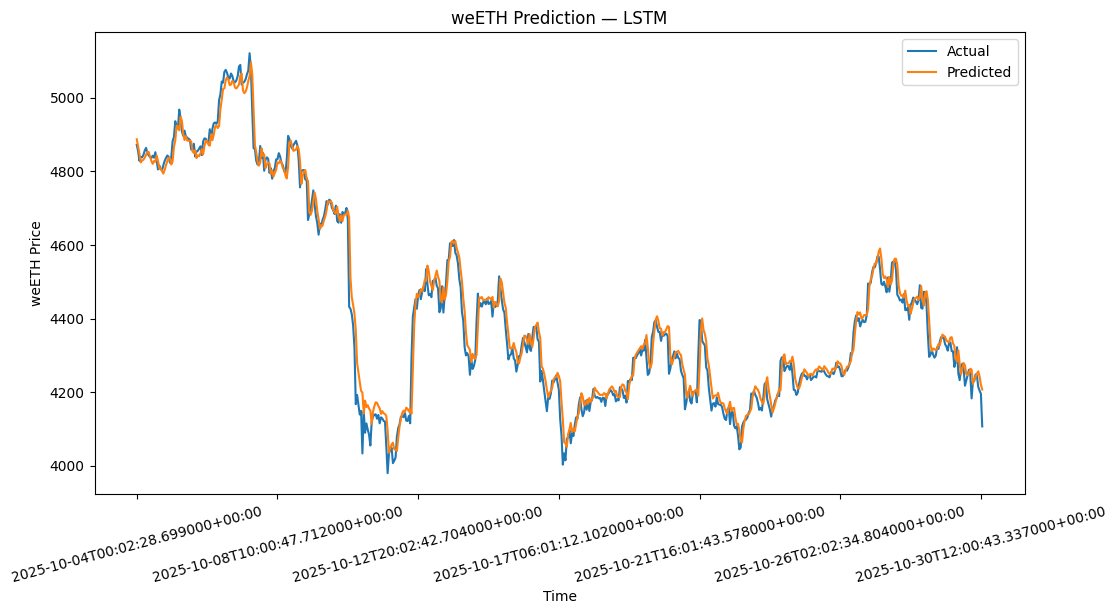

In [9]:
plt.figure(figsize=(12,6))

# 修正 dates 计算方式
dates = df['Open Time'][len(data_BTC) - len(y_true):]  

plt.plot(dates, y_true, label="Actual")
plt.plot(dates, y_pred, label="Predicted")
plt.title("weETH Prediction — LSTM")
plt.xlabel("Time")
plt.ylabel("weETH Price")
plt.legend()

step = max(1, len(dates)//6)
plt.xticks(dates[::step], rotation=15)
plt.show()

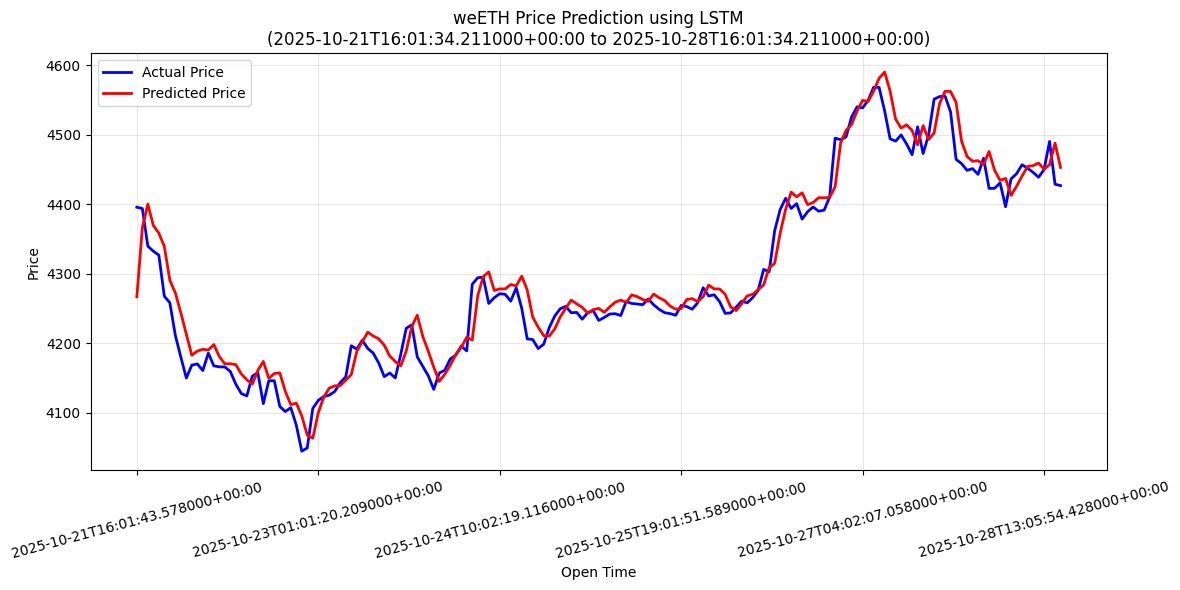

In [10]:
comparison_df = pd.DataFrame({
    'Open Time': df['Open Time'][len(data_BTC)-len(y_true):].values,
    'Actual_Price': y_true.flatten(),
    'Predicted_Price': y_pred.flatten()
})

# 定义日期范围
start_date = '2025-10-21T16:01:34.211000+00:00'
end_date = '2025-10-28T16:01:34.211000+00:00'

# 筛选指定日期范围的数据
filtered_df = comparison_df[
    (comparison_df['Open Time'] >= start_date) & 
    (comparison_df['Open Time'] <= end_date)
]

# 绘制筛选后的数据
plt.figure(figsize=(12,6))

plt.plot(filtered_df['Open Time'], filtered_df['Actual_Price'], color='blue', label='Actual Price', linewidth=2)
plt.plot(filtered_df['Open Time'], filtered_df['Predicted_Price'], color='red', label='Predicted Price', linewidth=2)

plt.title(f'weETH Price Prediction using LSTM\n({start_date} to {end_date})')
plt.xlabel('Open Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)

# 设置x轴日期显示格式 - 使用筛选后的数据
filtered_dates = filtered_df['Open Time']
step = max(1, len(filtered_dates) // 5)  # 显示5个日期标签
plt.xticks(filtered_dates[::step], rotation=15)

plt.tight_layout()
plt.show()

In [11]:
comparison_df

,Open Time,Actual_Price,Predicted_Price
0,2025-10-04T00:02:28.699000+00:00,4872.195503,4887.404495
1,2025-10-04T01:02:24.254000+00:00,4855.011851,4867.949336
2,2025-10-04T02:03:42.365000+00:00,4828.614439,4848.357381
3,2025-10-04T03:02:01.156000+00:00,4839.418886,4824.469685
4,2025-10-04T04:01:26.847000+00:00,4838.460532,4829.716388
...,...,...,...
633,2025-10-30T09:00:59.471000+00:00,4244.861582,4250.392371
634,2025-10-30T10:02:03.472000+00:00,4214.102545,4256.596886
635,2025-10-30T11:01:02.721000+00:00,4204.051703,4242.958770
636,2025-10-30T12:00:43.337000+00:00,4195.625746,4220.040861


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 已经反归一化的预测值和实际值
#y_true = y_test_actual.flatten()
#y_pred_flat = y_pred.flatten()

# 均方误差
mse = mean_squared_error(y_true, y_pred)
# 均方根误差
rmse = np.sqrt(mse)
# 平均绝对误差
mae = mean_absolute_error(y_true, y_pred)
# R²
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

MSE: 1457.6050
RMSE: 38.1786
MAE: 26.6635
R²: 0.9813
